In [2]:
# import tensorflow as tf

# from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import skimage.measure

import random
import copy
import math
import cv2
import os

/tmp/ipykernel_202038/193707349.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
div = 32
step = int(32/4)
red = 3

# Random sample 32x32 windows in map
n_crops = 100  #500

map_list = ['stanford_coupa0', 'stanford_coupa1', 'stanford_coupa2', 'stanford_coupa3', 'stanford_deathCircle0', 'stanford_gates2', 'stanford_hyang2', 'stanford_hyang3', 'stanford_hyang4', 'stanford_hyang10', 'stanford_little3', 'stanford_nexus0', 'stanford_nexus1']
# map_list = ['stanford_hyang1']
# semantic class cash is used also for bike parking spots
sem_dict = ['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree','restricted','grass','intersection','shadow']
chans = len(sem_dict)+1

lut_in = [0, 10, 30, 50, 70, 110, 150, 255]
lut_out = [0, 120, 200, 225, 240, 248, 250, 255]
lut_in = [0, 10, 70, 150, 255]
lut_out = [0, 130, 210, 245, 255]
# plt.plot(lut_in, lut_out)
lut_8u = np.interp(np.arange(0, 256), lut_in, lut_out).astype(np.uint8)

train_x = np.zeros((1, div, div, chans))
train_y = np.zeros((1, div, div))
train_y1 = np.zeros((1, div, div))
train_y2 = np.zeros((1, div, div))

spec = 'stan'
train_data_dir = 'training_data'

stanford_coupa0
Reduced map found
data max: 0.0007691271861328494
data min: 0.0
data sum: 1.0


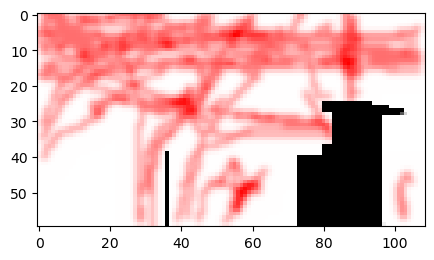

stanford_coupa1
Reduced map found
data max: 0.0006938030349670494
data min: 0.0
data sum: 0.9999999999999998


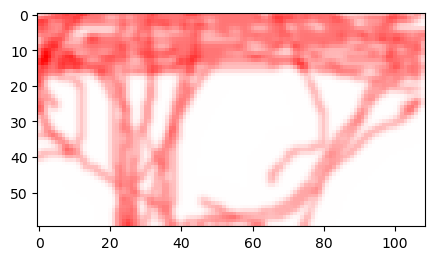

stanford_coupa2
Reduced map found
data max: 0.00041560224663122244
data min: 0.0
data sum: 1.0


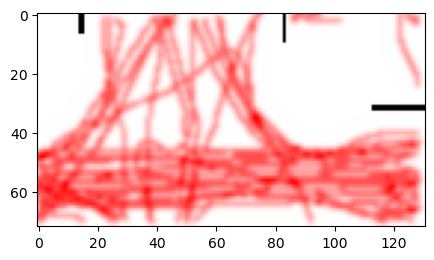

stanford_coupa3
Reduced map found
data max: 0.0006658583731830244
data min: 0.0
data sum: 1.0


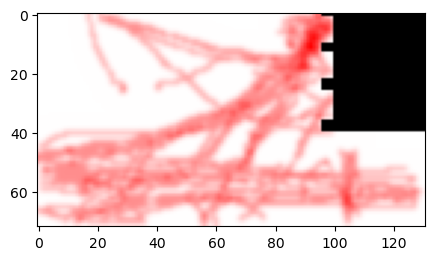

stanford_deathCircle0
Reduced map found
data max: 0.0017818929755737522
data min: 0.0
data sum: 1.0


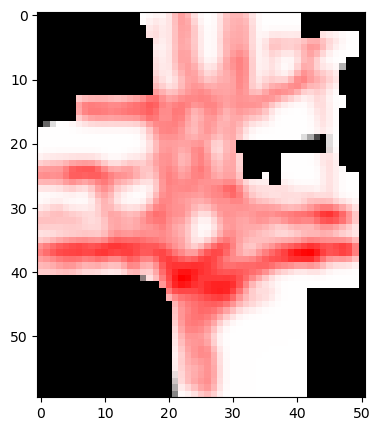

stanford_gates2
Reduced map found
data max: 0.0006748241644708308
data min: 0.0
data sum: 1.0


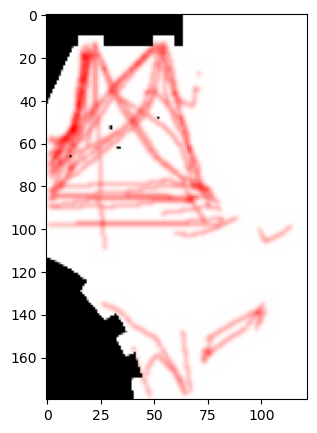

stanford_hyang2
Reduced map found
data max: 0.0013198313660789493
data min: 0.0
data sum: 1.0000000000000002


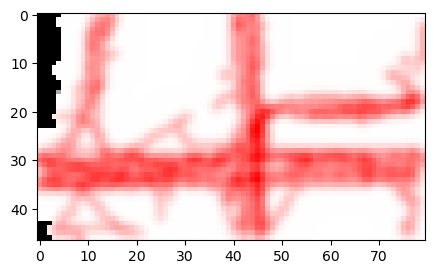

stanford_hyang3
Reduced map found
data max: 0.002284453697575621
data min: 0.0
data sum: 0.9999999999999998


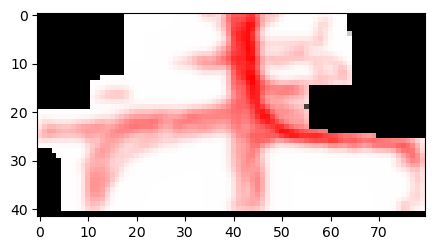

stanford_hyang4
Reduced map found
data max: 0.001762762929525292
data min: 0.0
data sum: 1.0


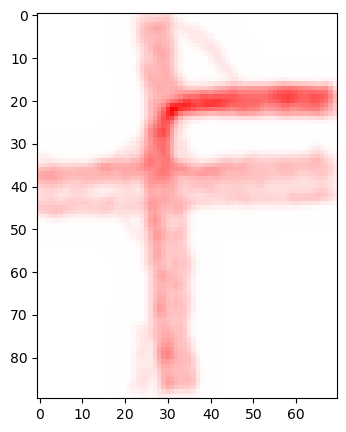

stanford_hyang10
Reduced map found
data max: 0.0023342775429595237
data min: 0.0
data sum: 1.0


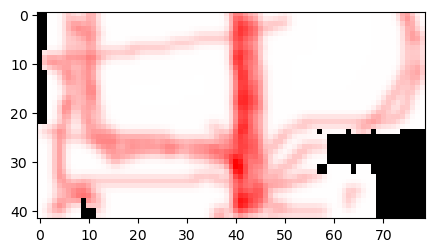

stanford_little3
Reduced map found
data max: 0.0011485858213918908
data min: 0.0
data sum: 1.0


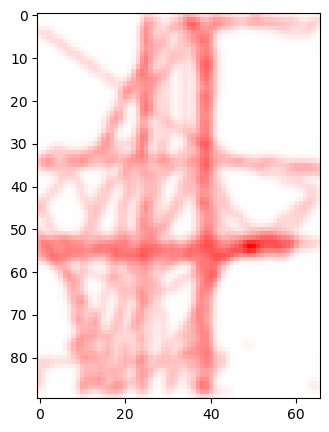

stanford_nexus0
Reduced map found
data max: 0.00189355189297287
data min: 0.0
data sum: 1.0


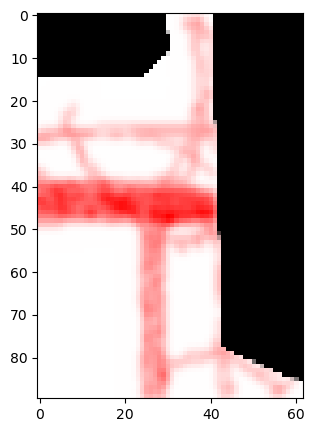

stanford_nexus1
Reduced map found
data max: 0.0011810834921518938
data min: 0.0
data sum: 1.0


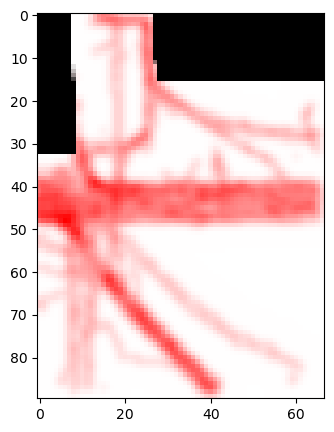

In [10]:
for map_count, map_name in enumerate(map_list):
  print(map_name)

  lines = 0
  try:
    with open('maps/semantics/'+map_name+'/'+map_name+'-reduced.csv') as f:
      print('Reduced map found')
      lines = f.readlines()
      
  except FileNotFoundError:
    with open('maps/semantics/'+map_name+'/'+map_name+'.csv') as f:
      print('Using original map')
      lines = f.readlines()

  h = len(lines)
  w = len(lines[0].split(','))

  # Converts data to a list of integers
  map = []
  for line in lines:
    map.extend([int(c) for c in line.split(',')])

  for lab_class in sem_dict:
    lines = 0
    try:
      with open('maps/semantics/'+map_name+'/'+map_name+'_sem_'+lab_class+'-reduced.csv') as f:
        lines = f.readlines()

      hh = len(lines)
      ww = len(lines[0].split(','))

      if hh != h or ww != w:
        print(f'h: {h}\tw: {w}')
        print(f'h: {hh}\tw: {ww}')
        raise SystemExit("ERROR: Different sizes!!")

      # Converts data to a list of integers
      for line in lines:
        map.extend([int(c) for c in line.split(',')])
    
    except FileNotFoundError:
      try:
        with open('maps/semantics/'+map_name+'/'+map_name+'_sem_'+lab_class+'.csv') as f:
          lines = f.readlines()

        hh = len(lines)
        ww = len(lines[0].split(','))

        if hh != h or ww != w:
          print(f'h: {h}\tw: {w}')
          print(f'h: {hh}\tw: {ww}')
          raise SystemExit("ERROR: Different sizes!!")

        # Converts data to a list of integers
        for line in lines:
          map.extend([int(c) for c in line.split(',')])

      except FileNotFoundError:
        for i in range(h):
          for j in range(w):
            map.extend([255])


  map = np.reshape(map,[chans,h,w])
  map = np.moveaxis(map, 0, -1)
  map = map/255

  map_aux = map
  map = np.zeros((int(math.ceil(h/red)),int(math.ceil(w/red)),chans))

  for idx in range(chans):
    map[:,:,idx] = skimage.measure.block_reduce(map_aux[:,:,idx], (red,red), np.max)

  # print(map.shape)
  h, w, _ = map.shape

  # -----------------------------------------------------------------------------------
  lines = 0
  with open('maps/semantics/'+map_name+'/humandensity-'+map_name+'-new.csv') as f:
    lines = f.readlines()

  hd = len(lines)
  wd = len(lines[0].split(','))

  # Converts data to a list of integers
  data = []
  for line in lines:
    data.extend([int(c) for c in line.split(',')])

  data = np.reshape(data,[hd,wd])
  sigma = 10.0
  # old_max = np.max(data)
  # data = skimage.filters.gaussian(data, sigma=(sigma, sigma), channel_axis=-1)
  # data = data/np.max(data)*old_max
  data = skimage.measure.block_reduce(data, (red,red), np.max)
  # data = np.subtract(data, np.full((h, w), np.min(data)))/(np.max(data)-np.min(data))
  data = data*(map[:,:,0]>0)

  # print(data.shape)
  hd, wd = data.shape
  
  sigma = 0.7
  data_show = data
  # data_show = cv2.LUT((data_show*255).astype(np.uint8), lut_8u).astype(np.float32)/255
  data_show = skimage.filters.gaussian(data_show, sigma=(sigma, sigma), channel_axis=-1)
  data_show = skimage.filters.gaussian(data_show, sigma=(sigma, sigma), channel_axis=-1)
  data = data_show/np.sum(data_show)
  data_show = data_show/np.max(data_show)
  print(f'data max: {np.max(data)}')
  print(f'data min: {np.min(data)}')
  print(f'data sum: {np.sum(data)}')
  fig = plt.figure(figsize=(5,5))
  # plt.imshow(data_show)
  plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data_show.shape,1),1-data_show,1-data_show),axis=2)))
  plt.show()


  # -----------------------------------------------------------------------------------
  lines = 0
  with open('maps/semantics/'+map_name+'/humandensity-'+map_name+'-vel.csv') as f:
    lines = f.readlines()

  hd = len(lines)
  wd = len(lines[0].split(','))

  # Converts data to a list of integers
  data1 = []
  for line in lines:
    data1.extend([float(c) for c in line.split(',')])

  data1 = np.reshape(data1,[hd,wd])
  sigma = 10.0
  data1 = skimage.filters.gaussian(data1, sigma=(sigma, sigma), channel_axis=-1)
  data1 = skimage.measure.block_reduce(data1, (red,red), np.max)
  data1 = np.subtract(data1, np.full((h, w), np.min(data1)))/(np.max(data1)-np.min(data1))

  # print(data1.shape)
  hd, wd = data1.shape

  # fig = plt.figure(figsize=(5,5))
  # plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data1.shape,1),1-data1,1-data1),axis=2)), vmin=0, vmax=1)
  # plt.show()

  # -----------------------------------------------------------------------------------
  lines = 0
  with open('maps/semantics/'+map_name+'/humandensity-'+map_name+'-stop.csv') as f:
    lines = f.readlines()

  hd = len(lines)
  wd = len(lines[0].split(','))

  # Converts data to a list of integers
  data2 = []
  for line in lines:
    data2.extend([float(c) for c in line.split(',')])

  data2 = np.reshape(data2,[hd,wd])
  sigma = 10.0
  data2 = skimage.filters.gaussian(data2, sigma=(sigma, sigma), channel_axis=-1)
  data2 = skimage.measure.block_reduce(data2, (red,red), np.max)
  data2 = np.subtract(data2, np.full((h, w), np.min(data2)))/(np.max(data2)-np.min(data2))

  # print(data2.shape)
  hd, wd = data2.shape

  # fig = plt.figure(figsize=(5,5))
  # plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data2.shape,1),1-data2,1-data2),axis=2)), vmin=0, vmax=1)
  # plt.show()

  # -----------------------------------------------------------------------------------
  # fig = plt.figure(figsize=(5,5))
  data_pred = np.zeros((int(math.ceil(h)),int(math.ceil(w))))
  data_pred1 = np.zeros((int(math.ceil(h)),int(math.ceil(w))))
  data_pred2 = np.zeros((int(math.ceil(h)),int(math.ceil(w))))

  num = 0
  numv = 0
  start = train_x.shape[0] - 1

  inserted = 0
  crops = np.zeros((n_crops,2),dtype=int)
  selections = np.zeros((h,w))
  for i in range(n_crops):
    background = np.zeros((h,w))
    flag = True
    while flag:
      aux_x = int(random.random()*(w-div+1))
      aux_y = int(random.random()*(h-div+1))
      flag = False

      submap = map[aux_y:aux_y+div, aux_x:aux_x+div,:]
      subdata = data[aux_y:aux_y+div, aux_x:aux_x+div]
      # subdata1 = data1[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div]
      # subdata2 = data2[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div]
      # subdata = np.divide(subdata,np.sum(subdata))

      if not (np.mean(submap) > 0.2 and np.mean(submap) < 1 and np.mean(subdata) > 0 and submap.shape == (div, div, chans)):
        # print('DISCARDED: not enough information')
        flag = True
        # test11 = 1-cv2.rectangle(background,(aux_x,aux_y),(aux_x+div-1,aux_y+div-1),(1,0,0),-1)/1.5
        # test11 = np.multiply(np.stack((test11,test11,test11),axis=2),np.stack((np.full(data.shape,1),1-data,1-data),axis=2))
        # test11 = np.multiply(test11,np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2))
        
        # for i in range(len(sem_dict)):
        #     alp = 0.5
        #     test11 = np.multiply(test11,np.stack((map[:,:,i+1],map[:,:,i+1],map[:,:,i+1]),axis=2)*alp+(1-alp))
        # plt.figure(figsize=(5,5))
        # plt.imshow(test11)

        # print(f'\nsubmap mean: {np.mean(submap)}')
        # print(f'subdata mean: {np.mean(subdata)}')
        # print(f'submap shape: {submap.shape}')
        # import sys
        # sys.exit(0)
      # print(f'INSERTED: {inserted}  ->  x: {aux_x} and y: {aux_y}')
      # for z in range(inserted):
      #   if abs(aux_x-crops[z,0])<int(div/10) and abs(aux_y-crops[z,1])<int(div/10):
      #     # print('too close')
      #     flag = True
        
    crops[i,0] = aux_x
    crops[i,1] = aux_y
    selections = selections+cv2.rectangle(background,(crops[i,0],crops[i,1]),(crops[i,0]+div-1,crops[i,1]+div-1),(1,0,0),-1)
    inserted = inserted + 1

    num = num + 1
    train_x = np.append(train_x, np.expand_dims(submap, axis=0), axis=0)
    train_y = np.append(train_y, np.expand_dims(subdata, axis=0), axis=0)
    # train_y1 = np.append(train_y1, np.expand_dims(subdata1, axis=0), axis=0)
    # train_y2 = np.append(train_y2, np.expand_dims(subdata2, axis=0), axis=0)

  selections = 1/selections

  for i in range(n_crops):
    submap = map[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div, :]
    subdata = data[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div]
    if np.max(subdata) > 1 or np.min(subdata) < 0:
      print(f'subdata max: {np.max(subdata)}')
      print(f'subdata min: {np.min(subdata)}')
    data_pred[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div] += subdata*selections[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div]
    # data_pred1[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div] += subdata1*selections[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div]
    # data_pred2[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div] += subdata2*selections[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div]
  
  data_show = data_pred/np.max(data_pred)

  # lim_val = 0.2
  # data_show = np.clip(data,0,np.max(data)*lim_val)/(np.max(data)*lim_val)
  # data_show = cv2.LUT((data_show*255).astype(np.uint8), lut_8u).astype(np.float32)/255
  fig = plt.figure(figsize=(5,5))
  plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data_show.shape,1),1-data_show,1-data_show),axis=2)))
  plt.show()
  
  # plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data_pred1.shape,1),1-data_pred1,1-data_pred1),axis=2)))
  # plt.show()
  # plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data_pred2.shape,1),1-data_pred2,1-data_pred2),axis=2)))
  # plt.show()

  # -----------------------------------------------------------------------------------


  for i in np.arange(num)+start:
    for j in np.arange(3):
      train_x = np.append(train_x, np.expand_dims(np.rot90(train_x[i,:,:], k=j+1, axes=(0, 1)),axis=0), axis=0)
      train_y = np.append(train_y, np.expand_dims(np.rot90(train_y[i,:,:], k=j+1, axes=(0, 1)),axis=0), axis=0)
      # train_y1 = np.append(train_y1, np.expand_dims(np.rot90(train_y1[i,:,:], k=j+1, axes=(0, 1)),axis=0), axis=0)
      # train_y2 = np.append(train_y2, np.expand_dims(np.rot90(train_y2[i,:,:], k=j+1, axes=(0, 1)),axis=0), axis=0)
    
    train_x = np.append(train_x, np.expand_dims(np.flip(train_x[i,:,:], axis=0), axis=0),axis=0)
    train_x = np.append(train_x, np.expand_dims(np.flip(train_x[i,:,:], axis=1), axis=0),axis=0)
    train_y = np.append(train_y, np.expand_dims(np.flip(train_y[i,:,:], axis=0), axis=0),axis=0)
    train_y = np.append(train_y, np.expand_dims(np.flip(train_y[i,:,:], axis=1), axis=0),axis=0)
    # train_y1 = np.append(train_y1, np.expand_dims(np.flip(train_y1[i,:,:], axis=0), axis=0),axis=0)
    # train_y1 = np.append(train_y1, np.expand_dims(np.flip(train_y1[i,:,:], axis=1), axis=0),axis=0)
    # train_y2 = np.append(train_y2, np.expand_dims(np.flip(train_y2[i,:,:], axis=0), axis=0),axis=0)
    # train_y2 = np.append(train_y2, np.expand_dims(np.flip(train_y2[i,:,:], axis=1), axis=0),axis=0)

  ############################################################################################################
  ############################################################################################################
  ############################################################################################################

  train_x = np.delete(train_x, 0, 0)
  train_y = np.delete(train_y, 0, 0)
  train_y1 = np.delete(train_y1, 0, 0)
  train_y2 = np.delete(train_y2, 0, 0)

  print(train_x.shape)
  
  np.savetxt(train_data_dir+'/'+map_name+'/train_X.csv', np.insert(train_x.flatten(),0,train_x.shape), delimiter=',', fmt='%f')
  np.savetxt(train_data_dir+'/'+map_name+'/train_Y.csv', np.insert(train_y.flatten(),0,train_y.shape), delimiter=',', fmt='%f')

  train_x = np.zeros((1, div, div, chans))
  train_y = np.zeros((1, div, div))
  train_y1 = np.zeros((1, div, div))
  train_y2 = np.zeros((1, div, div))

  ############################################################################################################
  ############################################################################################################
  ############################################################################################################

# # Show the random crop selection of the map
# fig = plt.figure(figsize=(w/12,h/12))
# plt.imshow(selections, vmin=0, vmax=1, cmap='magma')
# plt.colorbar()
# plt.show()

train_x = np.delete(train_x, 0, 0)
train_y = np.delete(train_y, 0, 0)
train_y1 = np.delete(train_y1, 0, 0)
train_y2 = np.delete(train_y2, 0, 0)

print(train_x.shape)


In [ ]:
# num_validation = 0.5
 
# original_data_x = train_x
# original_data_y = train_y
# original_data_y1 = train_y1
# original_data_y2 = train_y2

In [ ]:
# train_x = original_data_x
# train_y = original_data_y
# # train_y1 = original_data_y1
# # train_y2 = original_data_y2

# p = np.random.permutation(len(train_x))
# train_x = train_x[p]
# train_y = train_y[p]
# # train_y1 = train_y1[p]
# # train_y2 = train_y2[p]

# num = train_x.shape[0]
# num_test = int(num*num_validation)

# test_x = train_x[:num_test,:,:]
# test_y = train_y[:num_test,:,:]
# # test_y1 = train_y1[:num_test,:,:]
# # test_y2 = train_y2[:num_test,:,:]

# train_x = train_x[num_test:,:,:]
# train_y = train_y[num_test:,:,:]
# # train_y1 = train_y1[num_test:,:,:]
# # train_y2 = train_y2[num_test:,:,:]

# print(train_x.shape)
# print(test_x.shape)

In [ ]:
# np.savetxt(train_data_dir+'/train_X.csv', np.insert(train_x.flatten(),0,train_x.shape), delimiter=',', fmt='%f')
# np.savetxt(train_data_dir+'/train_Y.csv', np.insert(train_y.flatten(),0,train_y.shape), delimiter=',', fmt='%f')
# # np.savetxt(train_data_dir+'/train_Y1.csv', np.insert(train_y1.flatten(),0,train_y1.shape), delimiter=',', fmt='%f')
# # np.savetxt(train_data_dir+'/train_Y2.csv', np.insert(train_y2.flatten(),0,train_y2.shape), delimiter=',', fmt='%f')

# np.savetxt(train_data_dir+'/test_X.csv', np.insert(test_x.flatten(),0,test_x.shape), delimiter=',', fmt='%f')
# np.savetxt(train_data_dir+'/test_Y.csv', np.insert(test_y.flatten(),0,test_y.shape), delimiter=',', fmt='%f')
# # np.savetxt(train_data_dir+'/test_Y1.csv', np.insert(test_y1.flatten(),0,test_y1.shape), delimiter=',', fmt='%f')
# # np.savetxt(train_data_dir+'/test_Y2.csv', np.insert(test_y2.flatten(),0,test_y2.shape), delimiter=',', fmt='%f')

In [ ]:
# i = int(random.random()*test_x.shape[0])
# # i = 6359
# print(i)
# submap = test_x[i,:,:]
# subdata = test_y[i,:,:]

# print(sem_dict)
# plt.figure(figsize=(10,5))
# for i in range(len(sem_dict)):
#     ax = plt.subplot(1, len(sem_dict), i+1)
#     alp = 0.5
#     ax.imshow(np.multiply(np.stack((submap[:,:,i+1],submap[:,:,i+1],submap[:,:,i+1]),axis=2)*alp+(1-alp), np.stack((np.full(subdata.shape,1),1-subdata,1-subdata),axis=2)))
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
# plt.show()
# fig = plt.figure(figsize=(2,2))
# contrasted_subdata = cv2.LUT((subdata/np.max(subdata)*255).astype(np.uint8), lut_8u).astype(float)/255
# plt.imshow(np.multiply(np.stack((submap[:,:,0],submap[:,:,0],submap[:,:,0]),axis=2), np.stack((np.full(subdata.shape,1),1-subdata,1-subdata),axis=2)))
# plt.show()